In [ ]:
"""
PINN for the Black-Scholes Equation .

Solving the Black-Scholes equation using a Physics-Informed Neural Network (PINN).

The equation is: ∂V/∂t + r*S*∂V/∂S + 0.5*σ²*S²*∂²V/∂S² - r*V = 0
Domain: S in, t in
Terminal Condition (at t=T): V(S, T) = max(S - K, 0)
Boundary Conditions (BC):
  V(S_MIN, t) = 0
  V(S_MAX, t) = S_MAX - K * exp(-r * (T - t))

V: Option Price
S: Stock Price
t: Time
T: Maturity Time
K: Strike Price
r: Risk-free interest rate
σ: Volatility
"""

'\nPINN for the Black-Scholes Equation (TensorFlow Version).\n\nThis script demonstrates how to solve the Black-Scholes equation for a\nEuropean call option using a Physics-Informed Neural Network (PINN).\n\nThe equation is: ∂V/∂t + r*S*∂V/∂S + 0.5*σ²*S²*∂²V/∂S² - r*V = 0\nDomain: S in, t in\nTerminal Condition (at t=T): V(S, T) = max(S - K, 0)\nBoundary Conditions (BC):\n  V(S_MIN, t) = 0\n  V(S_MAX, t) = S_MAX - K * exp(-r * (T - t))\n\nV: Option Price\nS: Stock Price\nt: Time\nT: Maturity Time\nK: Strike Price\nr: Risk-free interest rate\nσ: Volatility\n'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [ ]:
# Seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# default data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

In [ ]:
# NEURAL NETWORK (PINN)
class PINN(tf.keras.Model):
    """
    A simple feed-forward neural network using Keras Model subclassing.
    """
    def __init__(self):
        super(PINN, self).__init__()
        # Input: 2 neurons (S, t)
        # Hidden Layers: 4 layers, 32 neurons each, with tanh activation
        # Output: 1 neuron (V)
        self.hidden1 = tf.keras.layers.Dense(32, activation='tanh')
        self.hidden2 = tf.keras.layers.Dense(32, activation='tanh')
        self.hidden3 = tf.keras.layers.Dense(32, activation='tanh')
        self.hidden4 = tf.keras.layers.Dense(32, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, s, t):
        # Forward pass
        # Concatenates stock price(S) and time(t) coordinates to form the input along the column dimension
        input_tensor = tf.concat([s, t], axis=1)
        x = self.hidden1(input_tensor)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        return self.output_layer(x)

In [ ]:
# PROBLEM PARAMETERS
# Financial parameters
R = 0.05       # Risk-free interest rate
SIGMA = 0.2    # Volatility
K = 100.0      # Strike price

# Domain boundaries
S_MIN, S_MAX = 0.0, 200.0
T_MIN, T_MAX = 0.0, 1.0  # Time to maturity (T) is 1 year

# Number of collocation points
N_physics = 25000  # Points inside the domain for the PDE loss
N_bc = 2500        # Points on the boundary (S=S_MIN, S=S_MAX)
N_terminal = 2500  # Points on the terminal time slice (t=T_MAX)

# Training parameters
EPOCHS = 20000
LEARNING_RATE = 1e-4

In [ ]:
# GENERATING COLLOCATION (TRAINING) POINTS

# Physics points (inside the domain)
s_physics = tf.random.uniform((N_physics, 1), S_MIN, S_MAX, dtype=DTYPE)
t_physics = tf.random.uniform((N_physics, 1), T_MIN, T_MAX, dtype=DTYPE)

# Boundary condition points (S_MIN and S_MAX)
t_bc = tf.random.uniform((N_bc, 1), T_MIN, T_MAX, dtype=DTYPE)
s_bc_min = tf.fill(t_bc.shape, S_MIN)
s_bc_max = tf.fill(t_bc.shape, S_MAX)

# True boundary values
# V(S_MIN, t) = 0
v_bc_min_true = tf.zeros_like(t_bc)
# V(S_MAX, t) = S_MAX - K * exp(-r * (T - t))
v_bc_max_true = S_MAX - K * tf.exp(-R * (T_MAX - t_bc))

# Terminal condition points (at t=T_MAX)
s_terminal = tf.random.uniform((N_terminal, 1), S_MIN, S_MAX, dtype=DTYPE)
t_terminal = tf.fill(s_terminal.shape, T_MAX)

# True terminal condition values V(S, T) = max(S - K, 0)
v_terminal_true = tf.nn.relu(s_terminal - K)


In [ ]:
# SETUP MODEL, OPTIMIZER, and LOSS FUNCTION
pinn = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
# THE TRAINING STEP (WRAPPED IN TF.FUNCTION FOR PERFORMANCE)
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        # Loss Components

        # 1. Boundary Condition (BC) Loss
        v_pred_bc_min = pinn(s_bc_min, t_bc)
        v_pred_bc_max = pinn(s_bc_max, t_bc)
        loss_bc = loss_fn(v_bc_min_true, v_pred_bc_min) + \
                  loss_fn(v_bc_max_true, v_pred_bc_max)

        # 2. Terminal Condition (TC) Loss
        v_pred_terminal = pinn(s_terminal, t_terminal)
        loss_terminal = loss_fn(v_terminal_true, v_pred_terminal)

        # 3. Physics (PDE) Loss
        # Use a nested GradientTape to compute derivatives of V w.r.t S and t
        with tf.GradientTape(persistent=True) as pde_tape:
            pde_tape.watch(s_physics)
            pde_tape.watch(t_physics)

            # Get the network's prediction
            v_physics = pinn(s_physics, t_physics)

            # First derivative w.r.t S
            dv_ds = pde_tape.gradient(v_physics, s_physics)

        # Second derivative w.r.t S
        d2v_ds2 = pde_tape.gradient(dv_ds, s_physics)
        # First derivative w.r.t t
        dv_dt = pde_tape.gradient(v_physics, t_physics)

        del pde_tape # Free up resources

        # Black-Scholes PDE residual
        physics_residual = dv_dt + R * s_physics * dv_ds + 0.5 * SIGMA**2 * s_physics**2 * d2v_ds2 - R * v_physics
        loss_physics = loss_fn(tf.zeros_like(physics_residual), physics_residual)

        # Total Loss
        total_loss = loss_physics + loss_bc + loss_terminal

    # Computing gradients and applying them to update the model's weights
    gradients = tape.gradient(total_loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

    return total_loss, loss_physics, loss_bc, loss_terminal

In [ ]:
print("Starting training...")
for epoch in range(EPOCHS):
    # one training step
    total_loss, loss_physics, loss_bc, loss_terminal = train_step()

    # Printing progress
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch, {epoch}"
              f"Loss: {total_loss.numpy():.4e}, "
              f"Physics: {loss_physics.numpy():.4e}, "
              f"BC: {loss_bc.numpy():.4e}, "
              f"Terminal: {loss_terminal.numpy():.4e}")

print("Training finished.")

Starting training...


Epoch, Loss: 9.8357e+03, Physics: 3.6644e-01, BC: 8.5855e+03, Terminal: 1.2498e+03
Epoch, Loss: 9.0244e+03, Physics: 5.3243e+00, BC: 7.9357e+03, Terminal: 1.0833e+03
Epoch, Loss: 8.3087e+03, Physics: 3.0737e+00, BC: 7.3509e+03, Terminal: 9.5475e+02
Epoch, Loss: 7.6546e+03, Physics: 3.0627e+00, BC: 6.8064e+03, Terminal: 8.4513e+02
Epoch, Loss: 7.0390e+03, Physics: 2.4073e+00, BC: 6.2903e+03, Terminal: 7.4631e+02
Epoch, Loss: 6.4574e+03, Physics: 2.2023e+00, BC: 5.7983e+03, Terminal: 6.5686e+02
Epoch, Loss: 5.9060e+03, Physics: 1.7716e+00, BC: 5.3285e+03, Terminal: 5.7575e+02
Epoch, Loss: 5.3836e+03, Physics: 1.5097e+00, BC: 4.8800e+03, Terminal: 5.0216e+02
Epoch, Loss: 4.8892e+03, Physics: 1.3988e+00, BC: 4.4523e+03, Terminal: 4.3555e+02
Epoch, Loss: 4.4220e+03, Physics: 1.4975e+00, BC: 4.0451e+03, Terminal: 3.7533e+02
Epoch, Loss: 3.9813e+03, Physics: 1.7117e+00, BC: 3.6585e+03, Terminal: 3.2105e+02
Epoch, Loss: 3.5665e+03, Physics: 1.9643e+00, BC: 3.2922e+03, Terminal: 2.7235e+02
Epoc

In [ ]:
# Analytical solution for validation (Black-Scholes formula for European Call)
def analytical_solution(S, t, K, r, sigma, T):
    if np.any(t == T): # Avoid division by zero at maturity
        t = T - 1e-8 # Add a small epsilon
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)
    call_price = 0 # Option is worthless if stock price is 0
    return call_price

/tmp/ipython-input-1760734862.py:5: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))


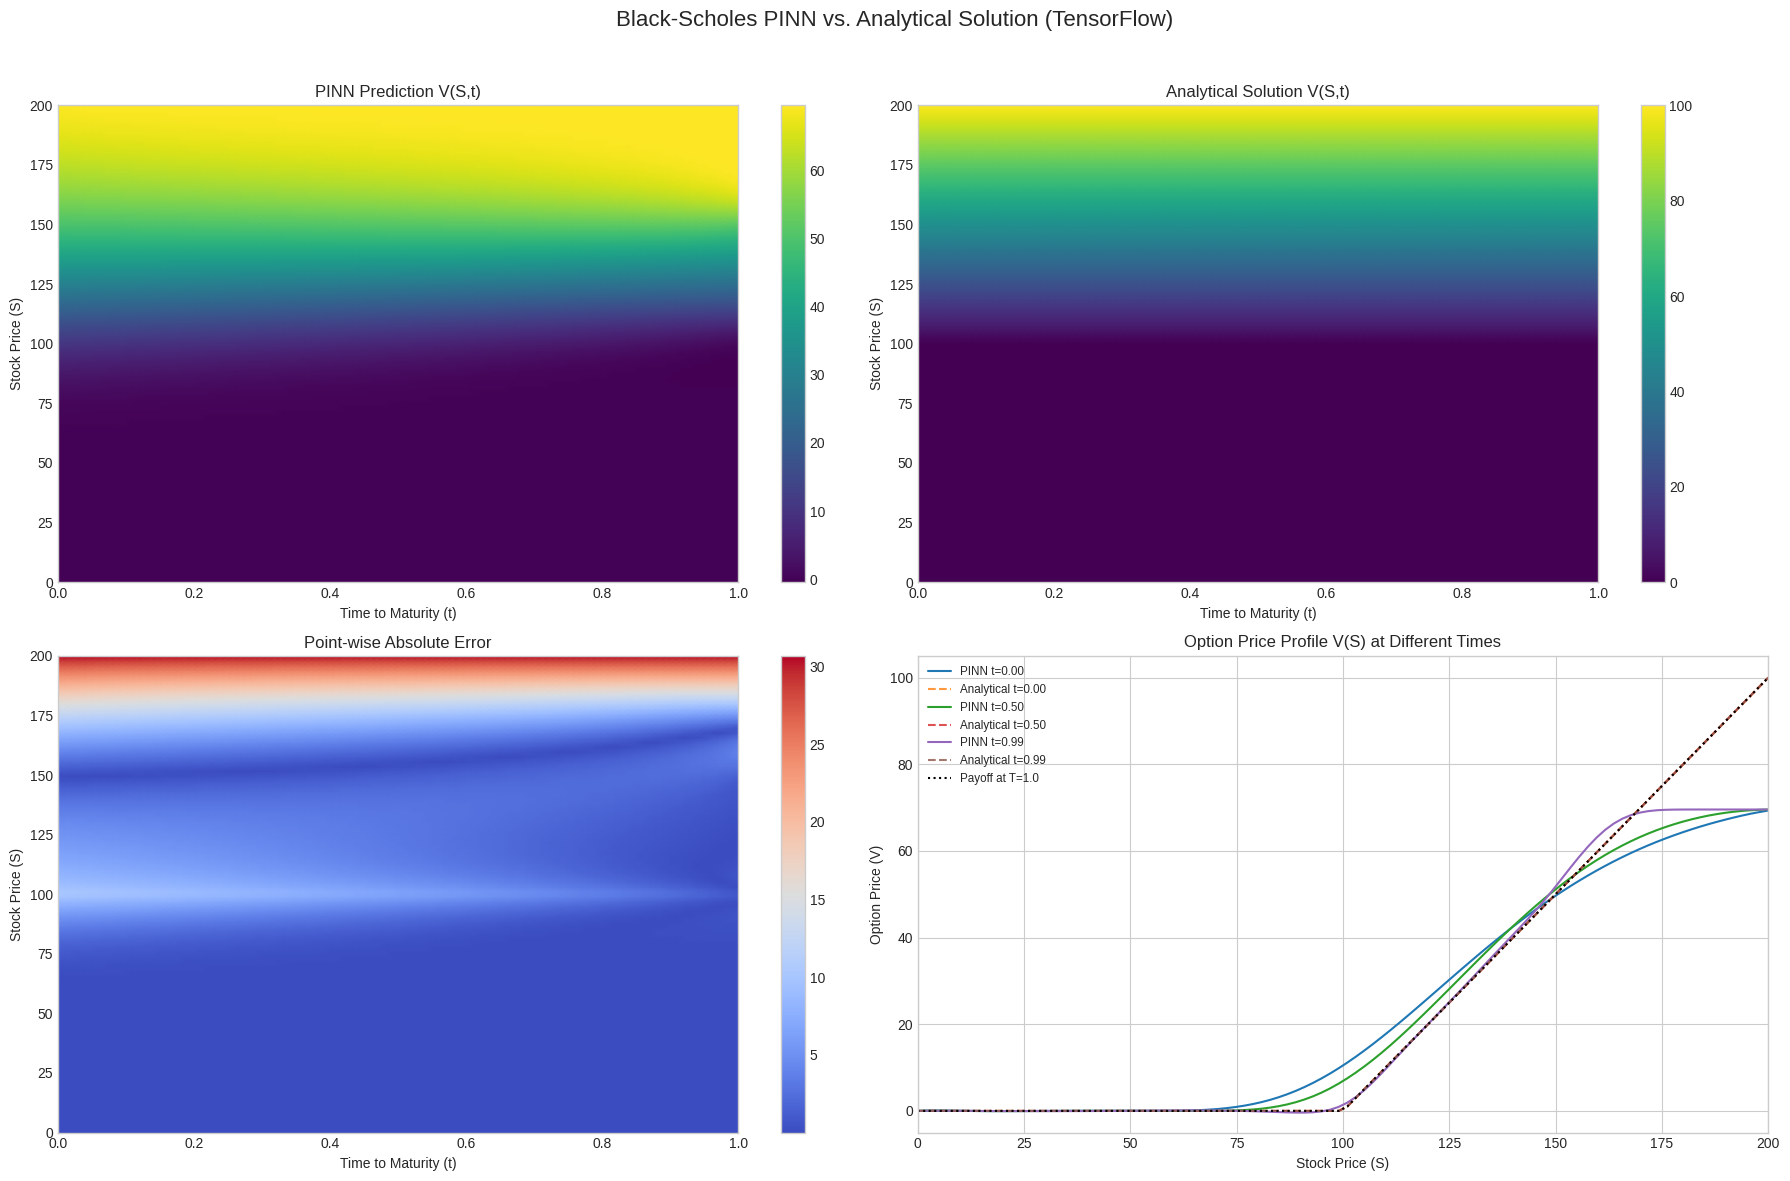

In [ ]:
print("Visualizing results...")
# Creating a grid for plotting
s_plot = np.linspace(S_MIN, S_MAX, 100)
t_plot = np.linspace(T_MIN, T_MAX, 100)
S_grid, T_grid = np.meshgrid(s_plot, t_plot)

# Flattening grid for network input
s_flat = tf.constant(S_grid.flatten(), dtype=DTYPE)
t_flat = tf.constant(T_grid.flatten(), dtype=DTYPE)

# Getting predictions from the PINN
v_pred_flat = pinn(s_flat[:, tf.newaxis], t_flat[:, tf.newaxis])

# Reshape predictions to the grid shape
V_pred = v_pred_flat.numpy().reshape(S_grid.shape)

# Calculating the analytical solution on the grid
V_analytical = analytical_solution(S_grid, T_grid, K, R, SIGMA, T_MAX)
V_analytical = np.maximum(S_grid - K, 0)

# Calculating the point-wise error
Error = np.abs(V_pred - V_analytical)

# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Black-Scholes PINN vs. Analytical Solution (TensorFlow)', fontsize=16)

# 1. PINN Prediction
ax1 = fig.add_subplot(2, 2, 1)
c1 = ax1.pcolormesh(T_grid, S_grid, V_pred, cmap='viridis', shading='gouraud')
fig.colorbar(c1, ax=ax1)
ax1.set_title('PINN Prediction V(S,t)')
ax1.set_xlabel('Time to Maturity (t)')
ax1.set_ylabel('Stock Price (S)')

# 2. Analytical Solution
ax2 = fig.add_subplot(2, 2, 2)
c2 = ax2.pcolormesh(T_grid, S_grid, V_analytical, cmap='viridis', shading='gouraud')
fig.colorbar(c2, ax=ax2)
ax2.set_title('Analytical Solution V(S,t)')
ax2.set_xlabel('Time to Maturity (t)')
ax2.set_ylabel('Stock Price (S)')

# 3. Point-wise Error
ax3 = fig.add_subplot(2, 2, 3)
c3 = ax3.pcolormesh(T_grid, S_grid, Error, cmap='coolwarm', shading='gouraud')
fig.colorbar(c3, ax=ax3)
ax3.set_title('Point-wise Absolute Error')
ax3.set_xlabel('Time to Maturity (t)')
ax3.set_ylabel('Stock Price (S)')

# 4. Option price profiles at different times
ax4 = fig.add_subplot(2, 2, 4)
times_to_plot = [0.0, 0.5, 0.99] # Plot at t=0, t=0.5, and just before maturity
for t_val in times_to_plot:
    t_idx = np.argmin(np.abs(t_plot - t_val))
    ax4.plot(s_plot, V_pred[t_idx, :], label=f'PINN t={t_val:.2f}')
    ax4.plot(s_plot, V_analytical[t_idx, :], '--', label=f'Analytical t={t_val:.2f}', alpha=0.8)

# Plotting the terminal condition (payoff function) for reference
ax4.plot(s_plot, np.maximum(s_plot - K, 0), 'k:', label=f'Payoff at T={T_MAX}')
ax4.set_title('Option Price Profile V(S) at Different Times')
ax4.set_xlabel('Stock Price (S)')
ax4.set_ylabel('Option Price (V)')
ax4.legend(fontsize='small')
ax4.grid(True)
ax4.set_xlim(S_MIN, S_MAX)
ax4.set_ylim(bottom=-5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()